In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 30 Lecture 1 Assignment

In this assignment, we will build our first random forest model. We will use a dataset containing churn information for a telephone company's customers.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer,
)

from category_encoders import LeaveOneOutEncoder

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Read in the telecom churn dataset.

https://raw.githubusercontent.com/Thinkful-Ed/data-science-lectures/master/telecom_churn.csv

In [3]:
data_url = "https://raw.githubusercontent.com/Thinkful-Ed/data-science-lectures/master/telecom_churn.csv"
df = pd.read_csv(data_url)
df.head(3)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes


<IPython.core.display.Javascript object>

In [4]:
# Convert Yes/No columns to bool
df = df.replace({"Yes": True, "No": False})

<IPython.core.display.Javascript object>

In [5]:
# Convert 'Unknown' to NaN in HandsetPrice column and make numeric
df["HandsetPrice"] = pd.to_numeric(df["HandsetPrice"], errors="coerce")

<IPython.core.display.Javascript object>

In [6]:
# Convert credit rating to int
# Example inputs: '1-Highest', '4-Medium', '3-Good'
df["CreditRating"] = pd.to_numeric(df["CreditRating"].str.split("-").str[0])

<IPython.core.display.Javascript object>

In [7]:
# Convert Homeownership to bool that indicates True if known home owner
df["Homeownership"] = df["Homeownership"] == "Known"

<IPython.core.display.Javascript object>

In [8]:
df.isna().mean().sort_values(ascending=False).head(15)

HandsetPrice             0.567751
AgeHH2                   0.017807
AgeHH1                   0.017807
PercChangeMinutes        0.007189
PercChangeRevenues       0.007189
MonthlyRevenue           0.003056
MonthlyMinutes           0.003056
TotalRecurringCharge     0.003056
DirectorAssistedCalls    0.003056
OverageMinutes           0.003056
RoamingCalls             0.003056
ServiceArea              0.000470
Handsets                 0.000020
CurrentEquipmentDays     0.000020
HandsetModels            0.000020
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
# Dropping handsetprice due to 57% missing values
df = df.drop(columns="HandsetPrice")

# Remove remaining NaN rows
df = df.dropna()

<IPython.core.display.Javascript object>

Perform the following preprocessing steps:

- This dataset has many columns; identify a subset of 10-15 features that you think could affect a customer's propensity to churn (also called "customer loss" or "customer attrition"). Include at least 1 categorical variable.
- Drop all rows that containing any missing values (this should be a fairly small number of rows)
- Convert the response from a string to a binary 1-0 encoding.

Although some implementations of tree-based models support categorical variables directly, scikit-learn's implementation does not, so we will need to convert our categorical variable(s) into numbers. In linear regression, we used one-hot/dummy encoding, but this has drawbacks that can be particularly problematic in the context of trees. Namely, dummy encoding can lead to very sparse columns when dealing with high-dimensional categorical features; the tree treats these levels as indepedent features is very unlikely to make a split on any of the individual levels, since the corresponding columns consist almost entirely consist of a single value.

Ideally, we would consider all of the levels simultaneously, which trees can do efficiently. However, sklearn does not implement this efficient algorithm for splitting on categorical variables. In this situation, a better alternative to dummy encoding is leave-one-out-encoding. This transforms each categorical into its conditional probability of the positive class, excluding the observation itself to avoid potential data leakage. Perform the following steps:

- Create an 80-20 train/test split on the data
- Fit a leave-one-out encoder to the training data and encode the categorical variables in the training data. The category_encoders package is helpful for this task. (Note that this ordering is important; if we fitted the encoder to the full dataset before making the train/test split, we would introduce data leakage by allowing the test data to affecting the estimates of the category-conditional probabilities.)

In [10]:
# fmt: off
num_cols = [
    "MonthlyRevenue", "MonthlyMinutes", "TotalRecurringCharge", 
    "DirectorAssistedCalls", "OverageMinutes", "RoamingCalls", 
    "PercChangeMinutes", "PercChangeRevenues", "DroppedCalls", 
    "BlockedCalls", "UnansweredCalls", "CustomerCareCalls",
    "ThreewayCalls", "ReceivedCalls", "OutboundCalls", "InboundCalls",
    "PeakCallsInOut", "OffPeakCallsInOut", "DroppedBlockedCalls",
    "CallForwardingCalls", "CallWaitingCalls", "MonthsInService",
    "UniqueSubs", "ActiveSubs", "Handsets", "HandsetModels",
    "CurrentEquipmentDays", "AgeHH1", "AgeHH2", "RetentionCalls",
    "RetentionOffersAccepted", "ReferralsMadeBySubscriber", "IncomeGroup",
    "AdjustmentsToCreditRating", "CreditRating",
]

bin_cols = [
    "ChildrenInHH", "HandsetRefurbished", "HandsetWebCapable",
    "TruckOwner", "RVOwner", "Homeownership", "BuysViaMailOrder",
    "RespondsToMailOffers", "OptOutMailings", "NonUSTravel",
    "OwnsComputer", "HasCreditCard", "NewCellphoneUser",
    "NotNewCellphoneUser", "OwnsMotorcycle", "MadeCallToRetentionTeam",
]
# fmt: on

cat_cols = ["ServiceArea", "PrizmCode", "Occupation", "MaritalStatus"]

<IPython.core.display.Javascript object>

In [11]:
X = df.drop(columns=["Churn", "CustomerID"])
y = df["Churn"]

<IPython.core.display.Javascript object>

In [12]:
y.value_counts(normalize=True)

False    0.71368
True     0.28632
Name: Churn, dtype: float64

<IPython.core.display.Javascript object>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [14]:
# Categorical feature encoding
encoder = LeaveOneOutEncoder(cols=cat_cols)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

X_train.head(2)

/usr/local/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
6896,40.18,193.0,45.0,0.0,0.0,1.9,-12.0,-1.2,4.0,1.3,...,False,0,7,False,0,False,1,0.303253,0.288,0.284326
34669,67.97,596.0,40.0,0.0,108.0,0.0,-33.0,-15.9,2.0,0.0,...,False,0,8,False,0,False,1,0.279723,0.288,0.284326


<IPython.core.display.Javascript object>

In [15]:
# Features selection
selector = SelectKBest(k=13)
selector.fit(X_train, y_train)

col_names = X_train.columns

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

<IPython.core.display.Javascript object>

In [16]:
X_train = pd.DataFrame(X_train, columns=col_names[selector.get_support()])
X_test = pd.DataFrame(X_test, columns=col_names[selector.get_support()])

X_train.head(2)

,MonthlyMinutes,TotalRecurringCharge,ReceivedCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,ServiceArea,HandsetModels,CurrentEquipmentDays,HandsetWebCapable,RetentionCalls,MadeCallToRetentionTeam,CreditRating
0,193,45,13.3,1.7,41,30,0.371429,1,946,False,0,False,1
1,596,40,62.9,9,129.3,77,0.278135,2,365,True,0,False,1


<IPython.core.display.Javascript object>

Next, fit the random forest model. You can tinker with or tune the parameters if you like, although we will use the default parameter values.

In [17]:
grid = {"max_depth": [4, 5, 6], "n_estimators": [50, 100, 200]}
model = GridSearchCV(
    RandomForestClassifier(),
    param_grid=grid,
    cv=2,
    #     scoring=make_scorer(f1_score),
    scoring=make_scorer(roc_auc_score),
    verbose=1,
)
model.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   20.7s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

<IPython.core.display.Javascript object>

In [18]:
model.best_params_

{'max_depth': 6, 'n_estimators': 200}

<IPython.core.display.Javascript object>

In [19]:
model.score(X_train, y_train)

0.5167883820057733

<IPython.core.display.Javascript object>

In [20]:
model.score(X_test, y_test)

0.5098882808682865

<IPython.core.display.Javascript object>

To evaluate our model, produce the predicted values for the test sample. Remember to apply our previously fitted encoder to the test data prior to making predictions.

In [21]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

<IPython.core.display.Javascript object>

After making the predictions, print out the classification report (sklearn.metrics.classification_report). In addition, plot the confusion matrix and ROC curve. How did our model perform?

In [ ]:
# not performing well, recall for class 1 is very poor.
# something would need to be done to improve this before deploying the model

In [22]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=["Predicted No Churn", "Predicted Churn"],
    index=["No Churn", "Churn"],
)

,Predicted No Churn,Predicted Churn
No Churn,7053,49
Churn,2773,76


<IPython.core.display.Javascript object>

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.99      0.83      7102
        True       0.61      0.03      0.05      2849

    accuracy                           0.72      9951
   macro avg       0.66      0.51      0.44      9951
weighted avg       0.69      0.72      0.61      9951



<IPython.core.display.Javascript object>

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc_score(y_test, y_prob[:, 1])

0.6224712727810446

<IPython.core.display.Javascript object>

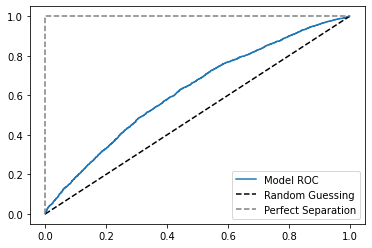

<IPython.core.display.Javascript object>

In [25]:
plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "--", c="gray", label="Perfect Separation")
plt.legend()
plt.show()

Print the feature importances, ordered by importance from high to low. What is the default sklearn feature importance metric?

In [26]:
# best sklearn specific write-up i could find:
# https://stackoverflow.com/a/15821880/5731525

<IPython.core.display.Javascript object>

In [27]:
# Most important features are:
#   * How long have customers had the equipment?
#   * Where are they located?
#   * How much do they use the service?
importance_df = pd.DataFrame(
    {"feat": X_train.columns, "importance": model.best_estimator_.feature_importances_}
)

importance_df = importance_df.sort_values("importance", ascending=False)
importance_df

,feat,importance
8,CurrentEquipmentDays,0.349766
6,ServiceArea,0.226261
0,MonthlyMinutes,0.109464
1,TotalRecurringCharge,0.049286
9,HandsetWebCapable,0.037995
12,CreditRating,0.035419
11,MadeCallToRetentionTeam,0.031446
4,PeakCallsInOut,0.030385
5,OffPeakCallsInOut,0.029998
10,RetentionCalls,0.028031


<IPython.core.display.Javascript object>